In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install ultralytics
!pip install roboflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 105.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from roboflow import Roboflow

# Store your API key in a variable (do NOT print it if you want to keep it secret)
robo_key = "iNqY8TjGSKAmKupTyEIE"

# Initialize Roboflow
rf = Roboflow(api_key=robo_key)

# Access the workspace and project using their slugs/IDs
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)

# Download the dataset in YOLOv11 format
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:02<00:00, 8203.65it/s] 


In [3]:
import os
import shutil

DATASET_PATH = "/kaggle/working/Fire-Smoke-Detection-Yolov11-2"

# OUTPUT PATH
OUTPUT_PATH = "classification_data"

CLASSES = {0: "Fire", 1: "Smoke"}

splits = ["train", "valid", "test"]

for split in splits:
    print(f"Processing {split}...")

    images_path = os.path.join(DATASET_PATH, split, "images")
    labels_path = os.path.join(DATASET_PATH, split, "labels")

    # Create output folders
    for cls in ["Fire", "Smoke", "Normal"]:
        os.makedirs(os.path.join(OUTPUT_PATH, split, cls), exist_ok=True)

    for img_name in os.listdir(images_path):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        base = os.path.splitext(img_name)[0]
        label_file = os.path.join(labels_path, base + ".txt")
        img_file = os.path.join(images_path, img_name)

        # Default class = NORMAL
        class_name = "Normal"

        # If label file exists and is not empty
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                lines = f.readlines()
                if len(lines) > 0:
                    first_class = int(lines[0].split()[0])
                    class_name = CLASSES.get(first_class, "Normal")

        # Copy image to class folder
        dest_folder = os.path.join(OUTPUT_PATH, split, class_name)
        shutil.copy(img_file, dest_folder)

print("Conversion Completed Successfully!")


Processing train...
Processing valid...
Processing test...
Conversion Completed Successfully!


In [5]:
import os

for split in ['train','valid','test']:
    root = f'/kaggle/working/classification_data/{split}'
    print("\n>>>", split.upper())
    print(os.listdir(root))



>>> TRAIN
['Smoke', 'Fire', 'Normal']

>>> VALID
['Smoke', 'Fire', 'Normal']

>>> TEST
['Smoke', 'Fire', 'Normal']


In [6]:
import os

normal_path = "/kaggle/working/classification_data/train/Normal"
print("Exists?", os.path.exists(normal_path))
print("Files:", os.listdir(normal_path)[:10])


Exists? True
Files: ['Img_1681_jpg.rf.5da52b757aed28fc303425b6e770301d.jpg', 'Img_1102_jpg.rf.068b7bdcc543d06ddb80adba2d8912cb.jpg', 'Datacluster-Fire-and-Smoke-Sample-40-_jpg.rf.1743724c400b13ecf46cd82d1ed823d4.jpg', 'Img_1101_jpg.rf.877833c95f35be951afee9bb096a0315.jpg']


In [7]:
import os

for split in ['train','valid','test']:
    normal_path = f"/kaggle/working/classification_data/{split}/Normal"
    print(f"\nChecking {split}/Normal:")
    print("Exists:", os.path.exists(normal_path))
    print("File count:", len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0)



Checking train/Normal:
Exists: True
File count: 4

Checking valid/Normal:
Exists: True
File count: 0

Checking test/Normal:
Exists: True
File count: 0


In [8]:
import os
import shutil
import random

# Paths (change if needed)
DATASET_PATH = "/kaggle/working/Fire-Smoke-Detection-Yolov11-2"
CLASS_DATA_PATH = "/kaggle/working/classification_data"

splits = ['train', 'valid', 'test']

TOTAL_NORMAL_PER_SPLIT = {
    'train': 80,
    'valid': 20,
    'test': 20
}

for split in splits:
    print(f"\nProcessing missing normals in {split}...")

    images_path = os.path.join(DATASET_PATH, split, "images")
    labels_path = os.path.join(DATASET_PATH, split, "labels")
    normal_dest = os.path.join(CLASS_DATA_PATH, split, "Normal")
    os.makedirs(normal_dest, exist_ok=True)

    # Find images WITHOUT labels
    unlabeled = []
    for img in os.listdir(images_path):
        if img.lower().endswith((".jpg", ".png", ".jpeg")):
            img_base = os.path.splitext(img)[0]
            label_file = os.path.join(labels_path, img_base + ".txt")
            if not os.path.exists(label_file):
                unlabeled.append(img)

    print(f"Found {len(unlabeled)} possible Normal images")

    # Randomly select required number
    needed = TOTAL_NORMAL_PER_SPLIT[split]
    selected = unlabeled[:needed] if len(unlabeled) >= needed else unlabeled

    for img_name in selected:
        src_img = os.path.join(images_path, img_name)
        shutil.copy(src_img, normal_dest)

    print(f"Added: {len(selected)} -> Normal folder")

print("\nDone! Normal class is now expanded properly.")



Processing missing normals in train...
Found 0 possible Normal images
Added: 0 -> Normal folder

Processing missing normals in valid...
Found 0 possible Normal images
Added: 0 -> Normal folder

Processing missing normals in test...
Found 0 possible Normal images
Added: 0 -> Normal folder

Done! Normal class is now expanded properly.


In [9]:
import os, shutil, random

RAW_NORMAL_PATH = "/kaggle/input/normal-images"
CLASS_DATA_PATH = "/kaggle/working/classification_data"

# Make sure target folders exist
for split in ['train','valid','test']:
    os.makedirs(os.path.join(CLASS_DATA_PATH, split, "Normal"), exist_ok=True)

# Collect all Normal images uploaded
files = [f for f in os.listdir(RAW_NORMAL_PATH) if f.lower().endswith(('.jpg','.png','.jpeg'))]
random.shuffle(files)

# Split them 
train_split = int(len(files) * 0.8)   # 80% train
valid_split = int(len(files) * 0.1)   # 10% valid
test_split  = len(files) - train_split - valid_split # 10% test

train_files = files[:train_split]
valid_files = files[train_split:train_split + valid_split]
test_files  = files[train_split + valid_split:]

# Helper function for copying
def add_files(file_list, split):
    for file in file_list:
        src = os.path.join(RAW_NORMAL_PATH, file)
        dst = os.path.join(CLASS_DATA_PATH, split, "Normal", file)
        shutil.copy(src, dst)

# Copy files to target
add_files(train_files, "train")
add_files(valid_files, "valid")
add_files(test_files, "test")

print("Normal images added successfully!")
print(f"Train: {len(train_files)}, Valid: {len(valid_files)}, Test: {len(test_files)}")


Normal images added successfully!
Train: 40, Valid: 5, Test: 5


In [10]:
import os

for split in ['train','valid','test']:
    normal_path = f"/kaggle/working/classification_data/{split}/Normal"
    print(f"\nChecking {split}/Normal:")
    print("Exists:", os.path.exists(normal_path))
    print("File count:", len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0)



Checking train/Normal:
Exists: True
File count: 44

Checking valid/Normal:
Exists: True
File count: 5

Checking test/Normal:
Exists: True
File count: 5


In [11]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 87.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
woodwork 0.31.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
mne 1.10.2 requires 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import os

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

DATA_DIR = '/kaggle/working/classification_data'
IMG_SIZE = 224
BATCH_SIZE = 16

# Force RGB conversion
def to_rgb(img):
    return img.convert("RGB")

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

#  TRAINING AUGMENTATIONS
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),  # zoom/crop
        transforms.RandomHorizontalFlip(),                        # flip
        transforms.RandomRotation(15),                            # rotation
        transforms.ColorJitter(
            brightness=0.3, contrast=0.3, saturation=0.3),        # brightness + saturation + color jitter
        transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),  # gaussian blur
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'valid': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.Resize(int(IMG_SIZE*1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'test': transforms.Compose([
        transforms.Lambda(to_rgb),
        transforms.Resize(int(IMG_SIZE*1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# Load dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), transform=data_transforms[x])
                  for x in ['train','valid','test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                             shuffle=(x=='train'))
               for x in ['train','valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)


Device: cuda
Classes: ['Fire', 'Normal', 'Smoke']
Dataset sizes: {'train': 9196, 'valid': 877, 'test': 440}


In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = CustomCNN(num_classes).to(DEVICE)
print(model)


CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [14]:
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

def train_model(model, max_epochs=50, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(max_epochs):
        print(f"\n🔹 Epoch {epoch+1}/{max_epochs}")
        
        for phase in ['train', 'valid']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()}")  # Progress bar
            
            for inputs, labels in pbar:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

                # Update progress bar metrics
                pbar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'valid':
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), "best_custom_cnn.pth")

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    print(f"🔸 Early Stop Counter: {early_stop_counter}/{patience}")

                if early_stop_counter >= patience:
                    print("\n⛔ Early Stopping Triggered!")
                    print(f"🏆 Best Validation Accuracy: {best_acc:.4f}")
                    return model

    print(f"\n🏁 Training Complete — Best Validation Accuracy: {best_acc:.4f}")
    return model

# 🚀 Start Training
trained_model = train_model(model, max_epochs=50, patience=5)



🔹 Epoch 1/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.5909 | Acc: 0.7820


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.3263 | Acc: 0.8734

🔹 Epoch 2/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.4487 | Acc: 0.8321


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.3232 | Acc: 0.8780

🔹 Epoch 3/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.4319 | Acc: 0.8399


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.3160 | Acc: 0.8974

🔹 Epoch 4/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.4242 | Acc: 0.8432


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.3036 | Acc: 0.8974

🔹 Epoch 5/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.4113 | Acc: 0.8463


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2942 | Acc: 0.8928

🔹 Epoch 6/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.4085 | Acc: 0.8515


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2846 | Acc: 0.9019

🔹 Epoch 7/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3949 | Acc: 0.8612


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.3083 | Acc: 0.8917
🔸 Early Stop Counter: 1/5

🔹 Epoch 8/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3851 | Acc: 0.8593


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2851 | Acc: 0.8928
🔸 Early Stop Counter: 2/5

🔹 Epoch 9/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3880 | Acc: 0.8569


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2764 | Acc: 0.9042

🔹 Epoch 10/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3775 | Acc: 0.8667


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2732 | Acc: 0.9008

🔹 Epoch 11/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3745 | Acc: 0.8666


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2587 | Acc: 0.9088

🔹 Epoch 12/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3687 | Acc: 0.8694


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2887 | Acc: 0.8985
🔸 Early Stop Counter: 1/5

🔹 Epoch 13/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3574 | Acc: 0.8730


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2522 | Acc: 0.9088

🔹 Epoch 14/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3576 | Acc: 0.8729


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2542 | Acc: 0.9088
🔸 Early Stop Counter: 1/5

🔹 Epoch 15/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3537 | Acc: 0.8758


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2590 | Acc: 0.9133
🔸 Early Stop Counter: 2/5

🔹 Epoch 16/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3506 | Acc: 0.8764


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2468 | Acc: 0.9202

🔹 Epoch 17/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3464 | Acc: 0.8774


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2573 | Acc: 0.9190
🔸 Early Stop Counter: 1/5

🔹 Epoch 18/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3474 | Acc: 0.8774


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2512 | Acc: 0.9088
🔸 Early Stop Counter: 2/5

🔹 Epoch 19/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3416 | Acc: 0.8802


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2444 | Acc: 0.9179

🔹 Epoch 20/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3341 | Acc: 0.8857


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2388 | Acc: 0.9179

🔹 Epoch 21/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3387 | Acc: 0.8832


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2436 | Acc: 0.9179
🔸 Early Stop Counter: 1/5

🔹 Epoch 22/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3401 | Acc: 0.8807


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2464 | Acc: 0.9202
🔸 Early Stop Counter: 2/5

🔹 Epoch 23/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3267 | Acc: 0.8844


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2599 | Acc: 0.9190
🔸 Early Stop Counter: 3/5

🔹 Epoch 24/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3110 | Acc: 0.8895


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2329 | Acc: 0.9236

🔹 Epoch 25/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3083 | Acc: 0.8919


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2457 | Acc: 0.9179
🔸 Early Stop Counter: 1/5

🔹 Epoch 26/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3054 | Acc: 0.8939


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2372 | Acc: 0.9190
🔸 Early Stop Counter: 2/5

🔹 Epoch 27/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.3030 | Acc: 0.8915


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2424 | Acc: 0.9213
🔸 Early Stop Counter: 3/5

🔹 Epoch 28/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2979 | Acc: 0.8928


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2329 | Acc: 0.9247
🔸 Early Stop Counter: 4/5

🔹 Epoch 29/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2886 | Acc: 0.8979


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2300 | Acc: 0.9247

🔹 Epoch 30/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2823 | Acc: 0.9009


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2357 | Acc: 0.9190
🔸 Early Stop Counter: 1/5

🔹 Epoch 31/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2840 | Acc: 0.8995


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2411 | Acc: 0.9236
🔸 Early Stop Counter: 2/5

🔹 Epoch 32/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2895 | Acc: 0.8981


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2539 | Acc: 0.9213
🔸 Early Stop Counter: 3/5

🔹 Epoch 33/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2846 | Acc: 0.9019


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2346 | Acc: 0.9247
🔸 Early Stop Counter: 4/5

🔹 Epoch 34/50


Train:   0%|          | 0/575 [00:00<?, ?it/s]

train Loss: 0.2806 | Acc: 0.9005


Valid:   0%|          | 0/55 [00:00<?, ?it/s]

valid Loss: 0.2350 | Acc: 0.9259
🔸 Early Stop Counter: 5/5

⛔ Early Stopping Triggered!
🏆 Best Validation Accuracy: 0.9259


In [35]:
# Load best model saved during training
trained_model = CustomCNN(num_classes).to(DEVICE)
trained_model.load_state_dict(torch.load("best_custom_cnn.pth"))
trained_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_acc = correct / total
print(f"\n Test Accuracy: {test_acc:.4f}")



 Test Accuracy: 0.9273



 Classification Report:

              precision    recall  f1-score   support

        Fire       0.92      1.00      0.96       343
      Normal       1.00      0.20      0.33         5
       Smoke       0.96      0.71      0.81        92

    accuracy                           0.93       440
   macro avg       0.96      0.63      0.70       440
weighted avg       0.93      0.93      0.92       440



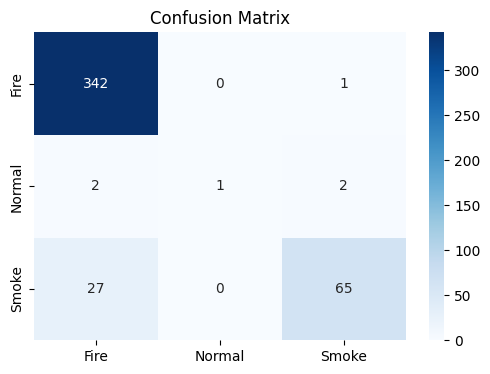

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

trained_model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


 Model Loaded Successfully!


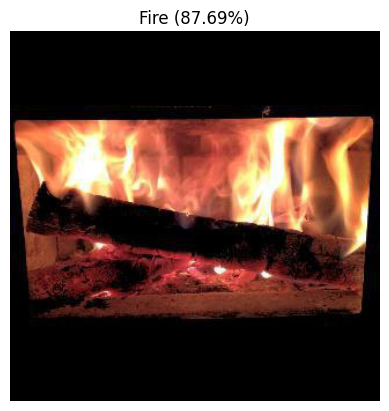

Prediction: Fire | Confidence: 87.69%


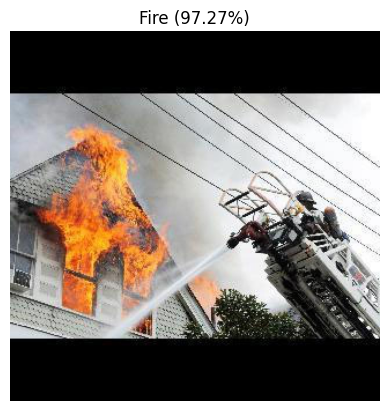

Prediction: Fire | Confidence: 97.27%


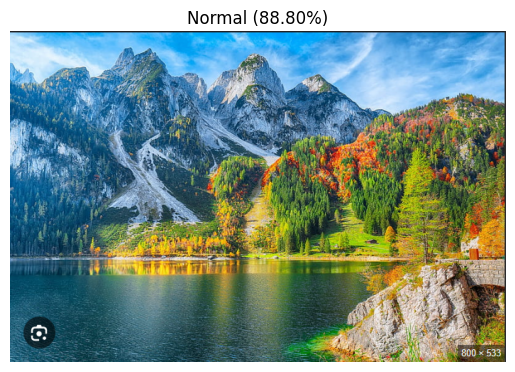

Prediction: Normal | Confidence: 88.80%


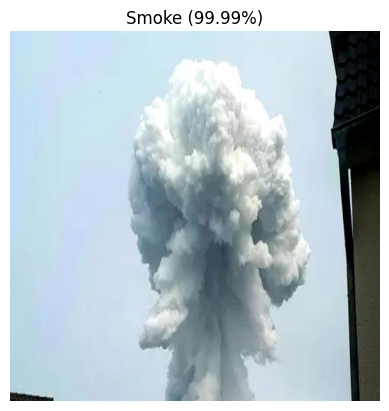

Prediction: Smoke | Confidence: 99.99%


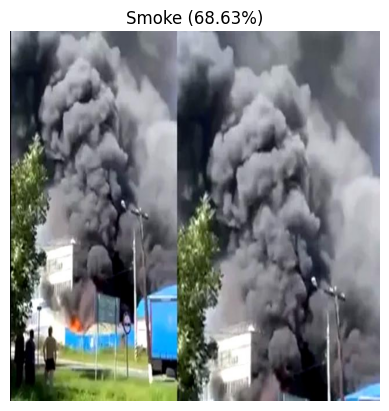

Prediction: Smoke | Confidence: 68.63%


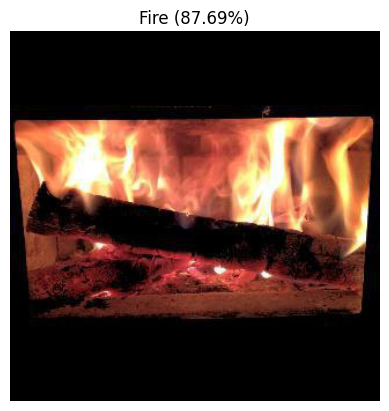

Prediction: Fire | Confidence: 87.69%


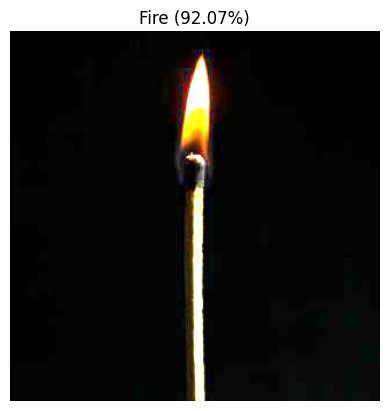

Prediction: Fire | Confidence: 92.07%


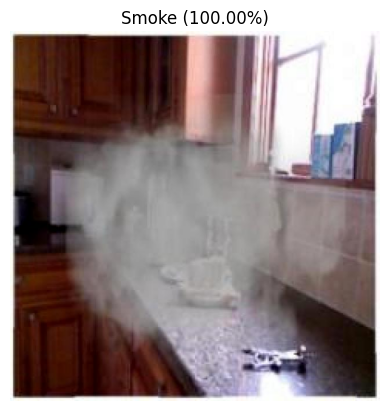

Prediction: Smoke | Confidence: 100.00%


In [33]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load best saved weights 
best_model = CustomCNN(num_classes).to(DEVICE)
best_model.load_state_dict(torch.load("best_custom_cnn.pth", map_location=DEVICE))
best_model.eval()

print(" Model Loaded Successfully!")

#  SINGLE IMAGE TEST
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transformed = data_transforms['test'](img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = best_model(transformed)
        prob = torch.softmax(output, 1)
        conf, pred = torch.max(prob, 1)

    label = class_names[pred.item()]
    conf = conf.item() * 100

    plt.imshow(img)
    plt.title(f"{label} ({conf:.2f}%)")
    plt.axis("off")
    plt.show()

    print(f"Prediction: {label} | Confidence: {conf:.2f}%")


#  Test any image:
predict_image("/kaggle/working/classification_data/test/Fire/0325403460c2d93c_jpg.rf.aa4a1a2e9f51b01464fbab25e4e790b2.jpg")
predict_image("/kaggle/working/classification_data/test/Fire/1006_jpg.rf.668e0ee5e5f8b010cc2068c20333ce62.jpg")
predict_image("/kaggle/working/classification_data/test/Normal/Screenshot 2025-12-01 170036.png")
predict_image("/kaggle/working/classification_data/test/Smoke/-539337_png.rf.35771d876c2a102ec6c75e999c9cdcfd.jpg")
predict_image("/kaggle/working/classification_data/test/Smoke/-848276_png.rf.e6cbccccc7b23ecf18060c7ad27ebca6.jpg")
predict_image("/kaggle/working/classification_data/test/Fire/0325403460c2d93c_jpg.rf.aa4a1a2e9f51b01464fbab25e4e790b2.jpg")
predict_image("/kaggle/working/classification_data/test/Fire/39_jpg.rf.2f29b5d2833a6c5f7c93bf1c2caf0cc7.jpg")
predict_image("/kaggle/working/classification_data/test/Smoke/H_09885_png_jpg.rf.b168278d45048719b496e39f99d705cd.jpg")
